In [1]:
from pathlib import Path
import numpy as np
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:

from prepro.nexrad import compute_nexrad_wave_form
from config import _EXAMPLEDATA_DIR


In [3]:
filename = Path(_EXAMPLEDATA_DIR, 'nexrad_level2', 'KSHV20230613_230228_V06')
radar_vol = pyart.io.read_nexrad_archive(filename)

In [4]:
nexrad_wave_form = compute_nexrad_wave_form(radar_vol)

print('from file: ', filename)
print(' wave_forms: ', nexrad_wave_form)                                       

from file:  /home/john.krause/python/hotspots/exampledata/nexrad_level2/KSHV20230613_230228_V06
 wave_forms:  ['surv', 'doppler', 'surv', 'doppler', 'surv', 'doppler', 'surv', 'doppler', 'surv', 'doppler', 'combined', 'combined', 'combined', 'combined', 'combined', 'combined', 'combined', 'combined', 'combined', 'combined', 'combined']


Now that we have the nexrad wave form for the volume we need to prune the volume to what we need.
In general to create a volumetric product we only use one elevation collected per volume. 
In the nexrad network there can be multiple cuts for each elevation before the 
volume is finished and the raw file written

These multiple cuts are due to SAILS and MERL being implemented on the nexrad network

After determining the nexrad_waveform for each cut we prune the data to include only data
from each elevation (first time collected) and for the waveform we want (surveillance or doppler) and 
then for the field type we are interested in, for nexrad this is usually once of the following
'cross_correlation_ratio', 'differential_phase', 'spectrum_width', 'differential_reflectivity', 'velocity', 'reflectivity'

We'll go about this by extracting the sweeps that match our input requirements and from those sweeps extracting the field that interests us. 

In [5]:
#print(radar_vol.metadata)
#print(radar_vol.sweep_mode)
#print(radar_vol.scan_rate)
print(radar_vol.sweep_number)
#print(radar_vol.fields)
#print(radar_vol.target_scan_rate)
sweep_number = radar_vol.sweep_number['data']
print('orig:', sweep_number)
#print(nyquist_velocity['data'].shape)
#print(np.unique(nyquist_velocity['data']))

#Set the sweep number to -1 to 'drop' that data
nexrad_wave = 'doppler'

index = 0
for d in nexrad_wave_form:
    #print (index,  ' d:', d)
    if d != "combined":
        #print('d: ', d)
        if d != nexrad_wave:
            sweep_number[index] = -1
    index += 1

print('modified:', sweep_number)

#now we select for only the first elevation collected
target_elev = radar_vol.fixed_angle['data']

index = 0
for e in target_elev:
    if sweep_number[index] != -1:
        #check for this elevation later in the volume
        #print( 'range:', range(index+1, len(target_elev)), 1)
        for i in range(index+1, len(target_elev)):
            #print('elev search:', i, ' target:', e, ' test: ', target_elev[i])
            if e == target_elev[i]:
                sweep_number[i] = -1
    index += 1
print('modified 2:', sweep_number)
       
#get a list of moment names from the dict. It is the first key
moment_names = list(radar_vol.fields.keys())
print(moment_names)



{'units': 'count', 'standard_name': 'sweep_number', 'long_name': 'Sweep number', 'data': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20], dtype=int32)}
orig: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
modified: [-1  1 -1  3 -1  5 -1  7 -1  9 10 11 12 13 14 15 16 17 18 19 20]
modified 2: [-1  1 -1  3 -1  5 -1  7 -1 -1 10 11 12 13 14 15 16 17 18 19 20]
['reflectivity', 'velocity', 'spectrum_width', 'cross_correlation_ratio', 'clutter_filter_power_removed', 'differential_phase', 'differential_reflectivity']


Now we have the unique one per volume elevation and on the wave form we want.
Go ahead and extract the data from the radar volume and push it into a new radar vol

Recomendations:<br /> 
'velocity' -> use doppler <br /> 
'horizontal_reflectivity' -> use either, probably surveillence <br /> 
'differential_phase' -> use surveillance <br /> 
'cross_correlation_ratio' -> use surveillance <br /> 
'differential_reflectivity' -> use surveillance <br /> 
'spectrum_width'  -> use either, probably doppler <br /> 


In [9]:
final_sweeps = []
for i in sweep_number:
    if i != -1:
        final_sweeps.append(i)
        
output_radar_vol = radar_vol.extract_sweeps(final_sweeps)

In [10]:
#output_radar_vol.info()
target_elev = output_radar_vol.fixed_angle['data']
print(target_elev)


[ 0.3076172   0.48339844  0.87890625  1.3183594   1.8017578   2.4169922
  3.1201172   3.9990234   5.0976562   6.4160156   7.998047   10.019531
 12.480469   15.600586   19.511719  ]


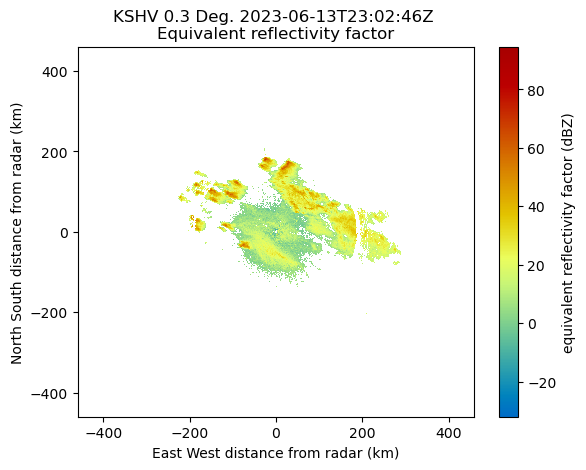

In [11]:
import matplotlib.pyplot as plt
display = pyart.graph.RadarDisplay(output_radar_vol)

display.plot_ppi('reflectivity', sweep=0)
plt.show()